# LSTNet SageMaker End to End

## Download datasets

In [1]:
#!git clone https://github.com/laiguokun/multivariate-time-series-data

## Unzip files

In [2]:
#!gunzip multivariate-time-series-data/electricity/electricity.txt.gz
#!gunzip multivariate-time-series-data/exchange_rate/exchange_rate.txt.gz
#!gunzip multivariate-time-series-data/solar-energy/solar_AL.txt.gz
#!gunzip multivariate-time-series-data/traffic/traffic.txt.gz

## Fetch file names and paths

In [3]:
import glob
file_paths = glob.glob("multivariate-time-series-data/*/*.txt")
print(file_paths)

['multivariate-time-series-data/traffic/traffic.txt', 'multivariate-time-series-data/exchange_rate/exchange_rate.txt', 'multivariate-time-series-data/solar-energy/solar_AL.txt', 'multivariate-time-series-data/electricity/electricity.txt']


## Select a time-series data

In [4]:
file_id = 3
file_path = file_paths[file_id]
text_file_name = file_paths[file_id].split('/')[-1]
print(text_file_name, file_path)

('electricity.txt', 'multivariate-time-series-data/electricity/electricity.txt')


# SageMaker Training Session

In [5]:
import  os
import  boto3
import  sagemaker
from sagemaker.mxnet import MXNet
from mxnet import gluon
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()

## Upload to S3

In [6]:
inputs = sagemaker_session.upload_data(path=file_path, key_prefix='data/LSTNet')

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-148886336128


## Set MXNet object

In [7]:
m = MXNet("lstnet.py", 
          role=role, 
          train_instance_count=1, 
          train_instance_type="ml.p2.xlarge",
          hyperparameters={'batch_size': 128, 
                           'epochs': 3,
                           'num_gpus': 1,
                           'conv_hid': 100,
                           'gru_hid': 100,
                           'skip_gru_hid': 5,
                           'skip': 24,
                           'ar_window': 24, 
                           'text_file': text_file_name
                          })

# Start training

In [8]:
m.fit(inputs)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-148886336128
INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-2018-06-19-18-43-01-239


..........................
2018-06-19 18:47:08,652 INFO - root - running container entrypoint
2018-06-19 18:47:08,653 INFO - root - starting train task
2018-06-19 18:47:08,673 INFO - container_support.training - Training starting
2018-06-19 18:47:11,202 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 1, 'channels': {u'training': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'network_interface_name': u'ethwe', u'hosts': [u'algo-1']}, 'user_script_name': u'lstnet.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'training': u'/opt/ml/input/data/training'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'output_dir': '/opt/ml/output', 'model_dir': '/opt/ml/model', 'hyperparameters': {u'sagemaker_program': u'lstnet.py', u'gru_hid': 100, u'text_file': u'electri

# SageMaker Inference Test

## Set inference endpoint

In [9]:
#from  sagemaker.mxnet.model  import MXNetModel
#
#training_job_name = m.latest_training_job.name
#sagemaker_model = MXNetModel(model_data= 's3://<s3 bucket>/{}/output/model.tar.gz'.format(training_job_name),
#                             role=role,
#                             entry_point='lstnet.py')

In [10]:
predictor = m.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-mxnet-2018-06-19-18-43-01-239
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-2018-06-19-18-43-01-239


--------------------------------------------------------------!

## Validate with the original data

In [11]:
from __future__ import print_function

from mxnet import gluon
import numpy as np


class TimeSeriesData(object):
    """
    Reads data from file and creates training and validation datasets
    """
    def __init__(self, file_path, window, horizon, train_ratio=0.8):
        """
        :param str file_path: path to the data file (e.g. electricity.txt)
        """
        # with open(file_path) as f:
        data = np.loadtxt(file_path, delimiter=',', dtype=np.float32)
        data = self._normalize(data)
        train_data_len = int(len(data) * train_ratio)
        self.num_series = data.shape[1]
        if train_ratio > 0.0:
            self.train = TimeSeriesDataset(data[:train_data_len], window=window, horizon=horizon)
        if train_ratio < 1.0:
            self.val = TimeSeriesDataset(data[train_data_len:], window=window, horizon=horizon)

    def _normalize(self, data):
        """ Normalizes data by maximum value per row (i.e. per time series) and saves the scaling factor

        :param np.ndarray data: input data to be normalized
        :return: normalized data
        :rtype np.ndarray
        """
        self.scale = np.max(data, axis=0)
        return data / self.scale


class TimeSeriesDataset(gluon.data.Dataset):
    """
    Dataset that splits the data into a dense overlapping windows
    """
    def __init__(self, data, window, horizon, transform=None):
        """
        :param np.ndarray data: time-series data in TC layout (T: sequence len, C: channels)
        :param int window: context window size
        :param int horizon: prediction horizon
        :param function transform: data transformation function: fn(data, label)
        """
        super(TimeSeriesDataset, self).__init__()
        self._data = data
        self._window = window
        self._horizon = horizon
        self._transform = transform

    def __getitem__(self, idx):
        """
        :param int idx: index of the item
        :return: single item in 'TC' layout
        :rtype np.ndarray
        """
        assert idx < len(self)
        data = self._data[idx:idx + self._window]
        label = self._data[idx + self._window + self._horizon - 1]
        if self._transform is not None:
            return self._transform(data, label)
        return data, label

    def __len__(self):
        """
        :return: length of the dataset
        :rtype int
        """
        return len(self._data) - self._window - self._horizon

## Make a time series object from a text file

In [12]:
ts_data = TimeSeriesData(file_path, window=24*7, horizon=24)

## From TS object to data-loader to MX ND array to Numpy array
End point predictor takes either list of numpy array data format. 

In [13]:
val_data_loader = gluon.data.DataLoader(ts_data.val, batch_size=2, shuffle=False, last_batch='discard')

In [14]:
import mxnet as mx
ctx = mx.cpu()
for data, label in val_data_loader:
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)
    break

In [15]:
preds = predictor.predict(data.asnumpy())

## Validation viz

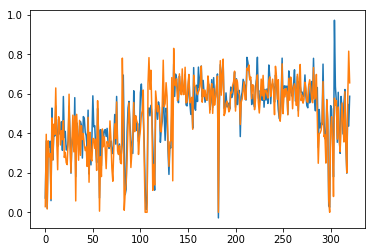

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(preds[0], label = 'prediction')
line2, = ax1.plot(label.asnumpy()[0], label = 'ground truth')
plt.show()

## Clean up the Endpoint

In [17]:
sagemaker.Session().delete_endpoint(predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: sagemaker-mxnet-2018-06-19-18-43-01-239


# End